# Imports

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from scipy import stats

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA, KernelPCA

from sklearn.svm import SVC

In [3]:
# does not contain predicted mean_A and mean_V values:
# df = pd.read_csv("dataset/phase_3_TRAIN_7d499bff69ca69b6_6372c3e_MLPC2021_generic.csv")

# contains our predicted meanA and meanV:
#df = pd.read_csv("dataset/dataset_with_predicted_mean_A_mean_V.csv")

# for working on google colab:
!wget -q "https://github.com/sh0w/machine-learning-pattern-classfication/raw/main/task3_classification/dataset/dataset_with_predicted_mean_A_mean_V.csv" -O "dataset.csv"
df = pd.read_csv("dataset.csv")


In [4]:
df = df.sample(frac=1, random_state=1337)
df.head()

,id,essentia_dissonance_mean,essentia_dissonance_stdev,essentia_dynamic_complexity,essentia_loudness,essentia_onset_rate,essentia_pitch_salience_mean,essentia_pitch_salience_stdev,essentia_spectral_centroid_mean,essentia_spectral_centroid_stdev,essentia_spectral_complexity_mean,essentia_spectral_complexity_stdev,essentia_spectral_rolloff_mean,essentia_spectral_rolloff_stdev,essentia_strong_peak_mean,essentia_strong_peak_stdev,librosa_bpm,librosa_chroma_mean_0,librosa_chroma_var_0,librosa_chroma_pct_10_0,librosa_chroma_pct_50_0,librosa_chroma_pct_90_0,librosa_chroma_mean_1,librosa_chroma_var_1,librosa_chroma_pct_10_1,librosa_chroma_pct_50_1,librosa_chroma_pct_90_1,librosa_chroma_mean_2,librosa_chroma_var_2,librosa_chroma_pct_10_2,librosa_chroma_pct_50_2,librosa_chroma_pct_90_2,librosa_chroma_mean_3,librosa_chroma_var_3,librosa_chroma_pct_10_3,librosa_chroma_pct_50_3,librosa_chroma_pct_90_3,librosa_chroma_mean_4,librosa_chroma_var_4,librosa_chroma_pct_10_4,...,librosa_chroma_pct_90_7,librosa_chroma_mean_8,librosa_chroma_var_8,librosa_chroma_pct_10_8,librosa_chroma_pct_50_8,librosa_chroma_pct_90_8,librosa_chroma_mean_9,librosa_chroma_var_9,librosa_chroma_pct_10_9,librosa_chroma_pct_50_9,librosa_chroma_pct_90_9,librosa_chroma_mean_10,librosa_chroma_var_10,librosa_chroma_pct_10,librosa_chroma_pct_50_10,librosa_chroma_pct_90_10,librosa_chroma_mean_11,librosa_chroma_var_11,librosa_chroma_pct_10_11,librosa_chroma_pct_50_11,librosa_chroma_pct_90_11,librosa_spectral_bandwidth_mean,librosa_spectral_bandwidth_stdev,librosa_spectral_flatness_mean,librosa_spectral_flatness_stdev,midlevel_features_melody,midlevel_features_articulation,midlevel_features_rhythm_complexity,midlevel_features_rhythm_stability,midlevel_features_dissonance,midlevel_features_tonal_stability,midlevel_features_minorness,score_mode,score_key_strength,mean_A,mean_V,quadrant,predicted_mean_A,predicted_mean_V,predicted_quadrant
635,FG-28-002,0.122095,0.064984,4.623885,16.808792,1.9,0.442560,0.124470,1244.223145,450.345795,1.261877,1.063901,497.583405,173.292694,0.110097,0.082302,123.046875,0.168287,0.025794,0.012234,0.119297,0.404820,0.129384,0.067159,0.010664,0.037753,0.249027,0.149382,0.051974,0.003142,0.034035,0.565548,0.252322,0.118199,0.003051,0.090084,1.000000,0.273661,0.096311,0.015340,...,0.809058,0.227878,0.100121,0.003855,0.050671,0.955240,0.173448,0.037948,0.007189,0.061975,0.469715,0.243706,0.103152,0.008352,0.069319,0.983863,0.301697,0.133138,0.006341,0.100657,1.000000,2656.823470,750.186868,0.000410,0.001268,0.261322,-0.233024,-0.255787,-0.097115,-0.398521,0.292226,-0.111223,1.0,0.731050,22.758621,-2.379310,3,25.401666,-3.317308,3
1305,SR-03-003,0.214142,0.055768,1.130288,419.003784,2.7,0.656047,0.088780,723.109863,95.818260,11.147161,1.943678,577.629333,152.584396,0.848315,0.525896,258.398438,0.629569,0.114835,0.153023,0.659614,1.000000,0.572834,0.072638,0.188343,0.610671,0.931793,0.394436,0.029693,0.199270,0.368337,0.634346,0.526755,0.071175,0.185575,0.517180,0.992999,0.611094,0.111368,0.157378,...,0.748548,0.365008,0.071540,0.086522,0.298397,0.832972,0.208181,0.035227,0.061849,0.139495,0.456054,0.278171,0.024971,0.104034,0.251671,0.487647,0.394446,0.051967,0.114268,0.371478,0.694759,838.944044,57.862493,0.000002,0.000001,-0.117364,-0.050167,-0.174743,-0.067654,-0.057992,0.174351,0.163383,1.0,0.697512,89.655172,-2.275862,2,64.835649,-1.420100,2
2247,RT-15-001,0.241415,0.092346,7.721171,17.821379,0.6,0.511267,0.120436,6452.331055,1776.684570,0.791425,0.887963,2136.538818,3469.742676,0.122791,0.189674,224.694293,0.161827,0.038402,0.006845,0.052099,0.434891,0.193585,0.033557,0.023033,0.131473,0.443500,0.546974,0.110421,0.097319,0.547017,1.000000,0.606206,0.128005,0.126031,0.531160,1.000000,0.412301,0.069543,0.061084,...,0.308953,0.294352,0.095027,0.010269,0.195234,0.823801,0.175470,0.034864,0.009461,0.122916,0.399263,0.134631,0.030015,0.002985,0.041942,0.371121,0.254727,0.113078,0.003290,0.055819,0.920238,6582.844878,517.111469,0.053048,0.053231,-0.040789,-0.

# Split dataset into inputs and targets

In [5]:
# drop target value, student annotations and string ID from input features:
X = df.drop(columns=['quadrant','mean_A','mean_V','id','score_mode','score_key_strength'])

# we want to predict the quadrant:
y = df['quadrant'].values

In [6]:
X.head()

,essentia_dissonance_mean,essentia_dissonance_stdev,essentia_dynamic_complexity,essentia_loudness,essentia_onset_rate,essentia_pitch_salience_mean,essentia_pitch_salience_stdev,essentia_spectral_centroid_mean,essentia_spectral_centroid_stdev,essentia_spectral_complexity_mean,essentia_spectral_complexity_stdev,essentia_spectral_rolloff_mean,essentia_spectral_rolloff_stdev,essentia_strong_peak_mean,essentia_strong_peak_stdev,librosa_bpm,librosa_chroma_mean_0,librosa_chroma_var_0,librosa_chroma_pct_10_0,librosa_chroma_pct_50_0,librosa_chroma_pct_90_0,librosa_chroma_mean_1,librosa_chroma_var_1,librosa_chroma_pct_10_1,librosa_chroma_pct_50_1,librosa_chroma_pct_90_1,librosa_chroma_mean_2,librosa_chroma_var_2,librosa_chroma_pct_10_2,librosa_chroma_pct_50_2,librosa_chroma_pct_90_2,librosa_chroma_mean_3,librosa_chroma_var_3,librosa_chroma_pct_10_3,librosa_chroma_pct_50_3,librosa_chroma_pct_90_3,librosa_chroma_mean_4,librosa_chroma_var_4,librosa_chroma_pct_10_4,librosa_chroma_pct_50_4,...,librosa_chroma_pct_90_6,librosa_chroma_mean_7,librosa_chroma_var_7,librosa_chroma_pct_10_7,librosa_chroma_pct_50_7,librosa_chroma_pct_90_7,librosa_chroma_mean_8,librosa_chroma_var_8,librosa_chroma_pct_10_8,librosa_chroma_pct_50_8,librosa_chroma_pct_90_8,librosa_chroma_mean_9,librosa_chroma_var_9,librosa_chroma_pct_10_9,librosa_chroma_pct_50_9,librosa_chroma_pct_90_9,librosa_chroma_mean_10,librosa_chroma_var_10,librosa_chroma_pct_10,librosa_chroma_pct_50_10,librosa_chroma_pct_90_10,librosa_chroma_mean_11,librosa_chroma_var_11,librosa_chroma_pct_10_11,librosa_chroma_pct_50_11,librosa_chroma_pct_90_11,librosa_spectral_bandwidth_mean,librosa_spectral_bandwidth_stdev,librosa_spectral_flatness_mean,librosa_spectral_flatness_stdev,midlevel_features_melody,midlevel_features_articulation,midlevel_features_rhythm_complexity,midlevel_features_rhythm_stability,midlevel_features_dissonance,midlevel_features_tonal_stability,midlevel_features_minorness,predicted_mean_A,predicted_mean_V,predicted_quadrant
635,0.122095,0.064984,4.623885,16.808792,1.9,0.442560,0.124470,1244.223145,450.345795,1.261877,1.063901,497.583405,173.292694,0.110097,0.082302,123.046875,0.168287,0.025794,0.012234,0.119297,0.404820,0.129384,0.067159,0.010664,0.037753,0.249027,0.149382,0.051974,0.003142,0.034035,0.565548,0.252322,0.118199,0.003051,0.090084,1.000000,0.273661,0.096311,0.015340,0.083293,...,1.000000,0.230650,0.099874,0.006525,0.045080,0.809058,0.227878,0.100121,0.003855,0.050671,0.955240,0.173448,0.037948,0.007189,0.061975,0.469715,0.243706,0.103152,0.008352,0.069319,0.983863,0.301697,0.133138,0.006341,0.100657,1.000000,2656.823470,750.186868,0.000410,0.001268,0.261322,-0.233024,-0.255787,-0.097115,-0.398521,0.292226,-0.111223,25.401666,-3.317308,3
1305,0.214142,0.055768,1.130288,419.003784,2.7,0.656047,0.088780,723.109863,95.818260,11.147161,1.943678,577.629333,152.584396,0.848315,0.525896,258.398438,0.629569,0.114835,0.153023,0.659614,1.000000,0.572834,0.072638,0.188343,0.610671,0.931793,0.394436,0.029693,0.199270,0.368337,0.634346,0.526755,0.071175,0.185575,0.517180,0.992999,0.611094,0.111368,0.157378,0.626064,...,0.837640,0.350897,0.067838,0.084353,0.274607,0.748548,0.365008,0.071540,0.086522,0.298397,0.832972,0.208181,0.035227,0.061849,0.139495,0.456054,0.278171,0.024971,0.104034,0.251671,0.487647,0.394446,0.051967,0.114268,0.371478,0.694759,838.944044,57.862493,0.000002,0.000001,-0.117364,-0.050167,-0.174743,-0.067654,-0.057992,0.174351,0.163383,64.835649,-1.420100,2
2247,0.241415,0.092346,7.721171,17.821379,0.6,0.511267,0.120436,6452.331055,1776.684570,0.791425,0.887963,2136.538818,3469.742676,0.122791,0.189674,224.694293,0.161827,0.038402,0.006845,0.052099,0.434891,0.193585,0.033557,0.023033,0.131473,0.443500,0.546974,0.110421,0.097319,0.547017,1.000000,0.606206,0.128005,0.126031,0.531160,1.000000,0.412301,0.069543,0.061084,0.387459,...,0.546247,0.140428,0.021281,0.010808,0.095772,0.308953,0.294352,0.095027,0.010269,0.195234,0.823801,0.175470,0.034864,0.009461,0.122916,0.399263

In [7]:
#split dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

# Simple SVM (no normalization)

In [8]:
# Create Support Vector Machine Classifier:
clf = SVC()

# Fit the classifier to the data
clf.fit(X_train, y_train)

clf.score(X_test, y_test)

0.5421455938697318

# Normalizing data drastically improves performance for SVM

In [9]:
X_normalized = MinMaxScaler().fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=1, stratify=y)

In [10]:
# Fit the classifier to the normalized data
clf.fit(X_train,y_train)

clf.score(X_test, y_test)

0.7873563218390804

# 1. SVM with Cross-Validation on Normalized Data with (optional) Feature Selection

In [12]:
pipeline = Pipeline([
        ("normalizer", MinMaxScaler()),
        ("selector", SelectKBest()),
        ('svm', SVC())
      ])

param_grid = {
    'selector__k': [4, 12, "all"],
    'svm__C': [1, 10, 100], 
    'svm__gamma': [1,0.1,0.01,0.001], 
    'svm__kernel': ['rbf', 'poly', 'linear', 'sigmoid']
}


grid = GridSearchCV(pipeline, param_grid, cv=5, return_train_score=True, n_jobs=-1, verbose=4)

#grid = RandomizedSearchCV(pipeline, param_grid, cv=5, return_train_score=True, n_jobs=-1, verbose=4, n_iter=10)

grid.fit(X, y)

scores_all_features = grid.cv_results_["mean_test_score"]

print("\n"+"#"*50,"\nbest estimator: ", grid.best_estimator_,"\n"+"#"*50,"\nbest params: ", grid.best_params_, "\n"+"#"*50,"\nbest score: ",grid.best_score_, "\n")


Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 609 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  4.2min finished



################################################## 
best estimator:  Pipeline(memory=None,
         steps=[('normalizer', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('selector',
                 SelectKBest(k='all',
                             score_func=<function f_classif at 0x7f0e079e57a0>)),
                ('svm',
                 SVC(C=10, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma=1, kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False) 
################################################## 
best params:  {'selector__k': 'all', 'svm__C': 10, 'svm__gamma': 1, 'svm__kernel': 'rbf'} 
################################################## 
best score:  0.8193284355902662 



# 2. Normalization => PCA => SVM

In [ ]:
pipeline = Pipeline([
        ("normalizer", StandardScaler()),
        ("pca", PCA()),
        ('svm', SVC())
      ])

param_grid = {
    'pca__n_components': [.75,.9,.98,"None"],
    'svm__C': [1, 10, 100], 
    'svm__gamma': [10,1,0.1], 
    'svm__kernel': ['rbf', 'poly', 'linear']
}

grid_pca = GridSearchCV(pipeline, param_grid, cv=5, return_train_score=True, n_jobs=-1, verbose=4)
#grid_pca = RandomizedSearchCV(pipeline, param_grid, cv=5, return_train_score=True, n_jobs=-1, verbose=4, n_iter=50)

grid_pca.fit(X, y)

scores_pca = grid_pca.cv_results_["mean_test_score"]

print("\n"+"#"*50,"\nbest estimator: ", grid_pca.best_estimator_,"\n"+"#"*50,"\nbest params: ", grid_pca.best_params_, "\n"+"#"*50,"\nbest score: ",grid_pca.best_score_, "\n")


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   21.0s


# 3. Normalizing => KernelPCA => LinearSVM 

In [22]:
from sklearn.svm import LinearSVC

pipeline = Pipeline([
        ("normalizer", StandardScaler()),
        ("kpca", KernelPCA()),
        ('svm', LinearSVC())
      ])

param_grid = {
    "kpca__kernel": ["rbf", "linear", "poly"],
    'kpca__n_components': [5, 20, 90],
    'svm__C': [1, 10, 100], 
    #'svm__penalty': ['l1','l2']
}


grid_kpca = GridSearchCV(pipeline, param_grid, cv=5, return_train_score=True, n_jobs=-1, verbose=4)
#grid_kpca = RandomizedSearchCV(pipeline, param_grid, cv=5, return_train_score=True, n_jobs=-1, verbose=4, n_iter=60)

grid_kpca.fit(X, y)

scores_kpca = grid_kpca.cv_results_["mean_test_score"]

print("\n"+"#"*50,"\nbest estimator: ", grid_kpca.best_estimator_,"\n"+"#"*50,"\nbest params: ", grid_kpca.best_params_, "\n"+"#"*50,"\nbest score: ",grid_kpca.best_score_, "\n")


Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:  3.3min finished



################################################## 
best estimator:  Pipeline(memory=None,
         steps=[('normalizer',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('kpca',
                 KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3,
                           eigen_solver='auto', fit_inverse_transform=False,
                           gamma=None, kernel='linear', kernel_params=None,
                           max_iter=None, n_components=90, n_jobs=None,
                           random_state=None, remove_zero_eig=False, tol=0)),
                ('svm',
                 LinearSVC(C=1, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='squared_hinge', max_iter=1000,
                           multi_class='ovr', penalty='l2', random_state=None,
                           tol=0.0001, verbose=0))],
         verbose=False) 
############################

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


# Evaluation

In [13]:
def plot_search_results(grid, title="Score per parameter", log_list=[]):
    """
    Params: 
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle(title, fontsize=26)
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical', fontsize=18)
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
        ax[i].set_xlabel(p.upper(), fontsize=18)
        if p in log_list: 
            ax[i].set_xscale('log')


    plt.legend()
    plt.show()



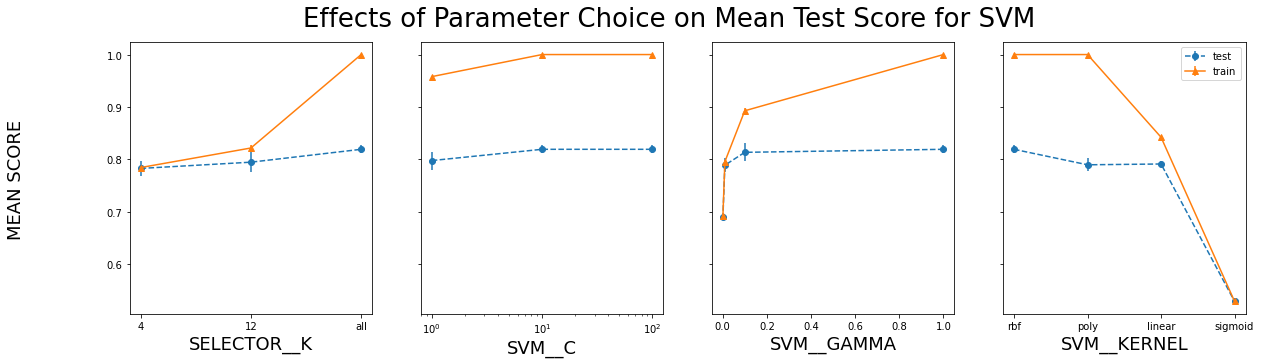

In [14]:
plot_search_results(grid, title="Effects of Parameter Choice on Mean Test Score for SVM",log_list=["svm__C"])

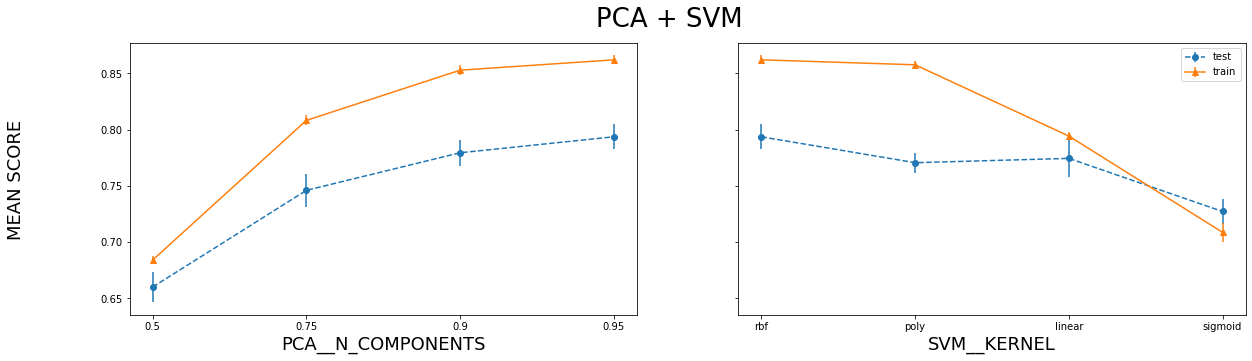

In [19]:
plot_search_results(grid_pca, title="Effects of Parameter choice for PCA & SVM", log_list=["svm__C"])

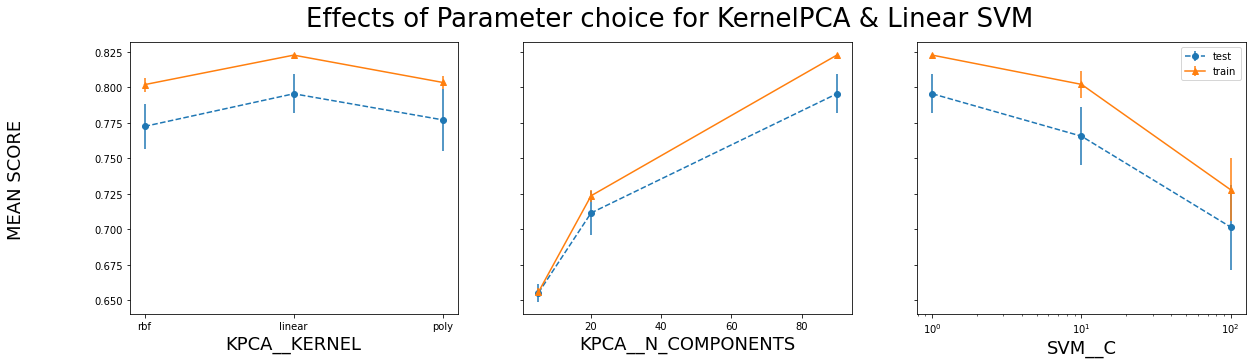

In [23]:
plot_search_results(grid_kpca, title="Effects of Parameter choice for KernelPCA & Linear SVM",log_list=["svm__C"])